# PRNet: Progressive Resolution based Network for Radiograph based disease classification

- Reproduce the architecture and results from the PRNet paper
  - paper link: file:///Users/Raahim/Documents/LUMS/Sophomore/Sophomore%20Summer%20semester%202025/research/maanz-ai%20internship/PRNet_Progressive_Resolution_based_Network_for_Radiograph_based_disease_classification.pdf (attach official link or github link)
  - dataset: https://cxr-covid19.grand-challenge.org/
  - backup dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database




## 0. Starter code

In [1]:
import os, random, time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.auto import tqdm
import shutil

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# fix random seeds for reproducibility
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_global_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 1. Readying code: Dataset, transforms and visualizations

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [4]:
import os

# List folders/files inside the dataset root directory
for root, dirs, files in os.walk(path):
    print(f"\nInspecting folder: {root}")
    print("Subdirectories:", dirs)
    print("Files:", files)
    # break  # Only list top-level directories (remove this to go deeper)



Inspecting folder: /kaggle/input/covid19-radiography-database
Subdirectories: ['COVID-19_Radiography_Dataset']
Files: []

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset
Subdirectories: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']
Files: ['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx']

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal
Subdirectories: ['images', 'masks']
Files: []

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images
Subdirectories: []
Files: ['Normal-859.png', 'Normal-158.png', 'Normal-10121.png', 'Normal-1811.png', 'Normal-97.png', 'Normal-1088.png', 'Normal-5663.png', 'Normal-6328.png', 'Normal-8410.png', 'Normal-5641.png', 'Normal-4852.png', 'Normal-9518.png', 'Normal-6443.png', 'Normal-6391.png', 'Normal-8481.png', 'Normal-3896.png', '

In [5]:
# set the base paths
base_dataset_path = os.path.join(path, "COVID-19_Radiography_Dataset")
output_base = "data"
splits = ['train', 'val', 'test']
split_ratio = [0.8, 0.1, 0.1]  # 70% train, 15% val, 15% test
classes = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

# create output directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

# function to split and copy images
for class_name in classes:
    source_dir = os.path.join(base_dataset_path, class_name, "images")
    all_images = os.listdir(source_dir)
    random.shuffle(all_images)
    n_total = len(all_images)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train + n_val]
    test_images = all_images[n_train + n_val:]

    def copy_images(image_list, split_name):
        for image in tqdm(image_list, desc=f"{split_name} - {class_name}"):
            src = os.path.join(source_dir, image)
            dst = os.path.join(output_base, split_name, class_name, image)
            shutil.copyfile(src, dst)
    copy_images(train_images, "train")
    copy_images(val_images, "val")
    copy_images(test_images, "test")

train - COVID:   0%|          | 0/2892 [00:00<?, ?it/s]

val - COVID:   0%|          | 0/361 [00:00<?, ?it/s]

test - COVID:   0%|          | 0/363 [00:00<?, ?it/s]

train - Normal:   0%|          | 0/8153 [00:00<?, ?it/s]

val - Normal:   0%|          | 0/1019 [00:00<?, ?it/s]

test - Normal:   0%|          | 0/1020 [00:00<?, ?it/s]

train - Viral Pneumonia:   0%|          | 0/1076 [00:00<?, ?it/s]

val - Viral Pneumonia:   0%|          | 0/134 [00:00<?, ?it/s]

test - Viral Pneumonia:   0%|          | 0/135 [00:00<?, ?it/s]

train - Lung_Opacity:   0%|          | 0/4809 [00:00<?, ?it/s]

val - Lung_Opacity:   0%|          | 0/601 [00:00<?, ?it/s]

test - Lung_Opacity:   0%|          | 0/602 [00:00<?, ?it/s]

In [6]:
# loading dataset
# class ChestXRayDataset(Dataset):
#   def __init__(self, root_dir: str, class_names: list, transform=None):
#     self.image_paths = []
#     self.labels = []
#     for idx, class_name in enumerate(class_names):
#       class_dir = os.path.join(root_dir, class_name)
#       files = glob(class_dir) # get all images of each class
#       self.image_paths += files
#       self.labels += [idx] * len(files) # appends label for each class image found
#     self.transform = transform

#   def __len__(self):
#     return len(self.image_paths)

#   def __getitem__(self, index):
#     image_path = self.image_paths[index]
#     image = Image.open(image_path).convert("RGB")
#     label = self.labels[index]
#     if self.transform:
#       image = self.transform(image)
#     return image, label
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, class_names, transform=None):
        # self.data_dir = data_dir
        # self.class_names = class_names
        # self.transform = transform
        # self.image_paths = []
        # self.labels = []
        # for class_name in class_names:
        #     class_dir = os.path.join(data_dir, class_name)
        #     for fname in os.listdir(class_dir):
        #         fpath = os.path.join(class_dir, fname)
        #         if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        #             self.image_paths.append((fpath, class_name))
        #             self.labels.append()
        self.image_paths = []
        self.labels = []
        for idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png','jpg','jpeg')):
                    self.image_paths.append(fpath)
                    self.labels.append(idx)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image) # PIL → H×W×C numpy array
        if self.transform:
            augmented = self.transform(image=image) # must pass as keyword
            image = augmented['image'] # grab the transformed tensor

        return image, label

In [7]:
# transformations
def get_train_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        # A.RandomBrightness(limit=0.2, p=0.3), # changes image brightness to mimic lighting variation # search for right import
        # A.RandomContrast(limit=0.2, p=0.3), # modifies contrast to handle visual differences
        A.Blur(blur_limit=3, p=0.2), # general softening of the image
        A.MedianBlur(blur_limit=3, p=0.2), # removes noise while keeping edges sharp
        A.GaussianBlur(blur_limit=(3,5), p=0.2), # natural smooth blur like out-of-focus camera
        A.MotionBlur(blur_limit=5, p=0.2), # simulates camera shake or patient movement
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3), # distorts image with grid pattern
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3), # adjusts tint, saturation, brightness
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5), # shifts, zooms, rotates image slightly
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ])


In [8]:
# visualize images
def imshow(img_tensor, mean, std):
    """
    img_tensor: C×H×W torch Tensor, normalized
    mean, std: sequences of length C
    returns: H×W×C numpy array in [0,1]
    """
    # move to C×H×W numpy
    img = img_tensor.cpu().numpy()
    # unnormalize per channel
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    # transpose to H×W×C
    img = np.transpose(img, (1,2,0))
    # clip to valid range
    return np.clip(img, 0, 1)

def show_batch(dataset, class_names, num_samples=16):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))

    # constants – must match your Normalize()
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    n = int(num_samples**0.5)  # for a 4×4 grid if num_samples=16
    fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))

    for ax, img_t, lab in zip(axes.flatten(), images, labels):
        img = imshow(img_t, mean, std)
        ax.imshow(img)
        ax.set_title(class_names[lab], fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# def show_batch(dataset, class_names, num_samples=16):
#     loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
#     images, labels = next(iter(loader))
#     # 4×4 grid
#     n = int(num_samples**0.5)
#     fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))
#     for ax, img, lab in zip(axes.flatten(), images, labels):
#         # img is C×H×W tensor in [0,1]; move to H×W×C:
#         ax.imshow(img.permute(1, 2, 0).cpu().numpy())
#         ax.set_title(class_names[lab], fontsize=12)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

/tmp/ipython-input-7-2687364321.py:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Raw images: 


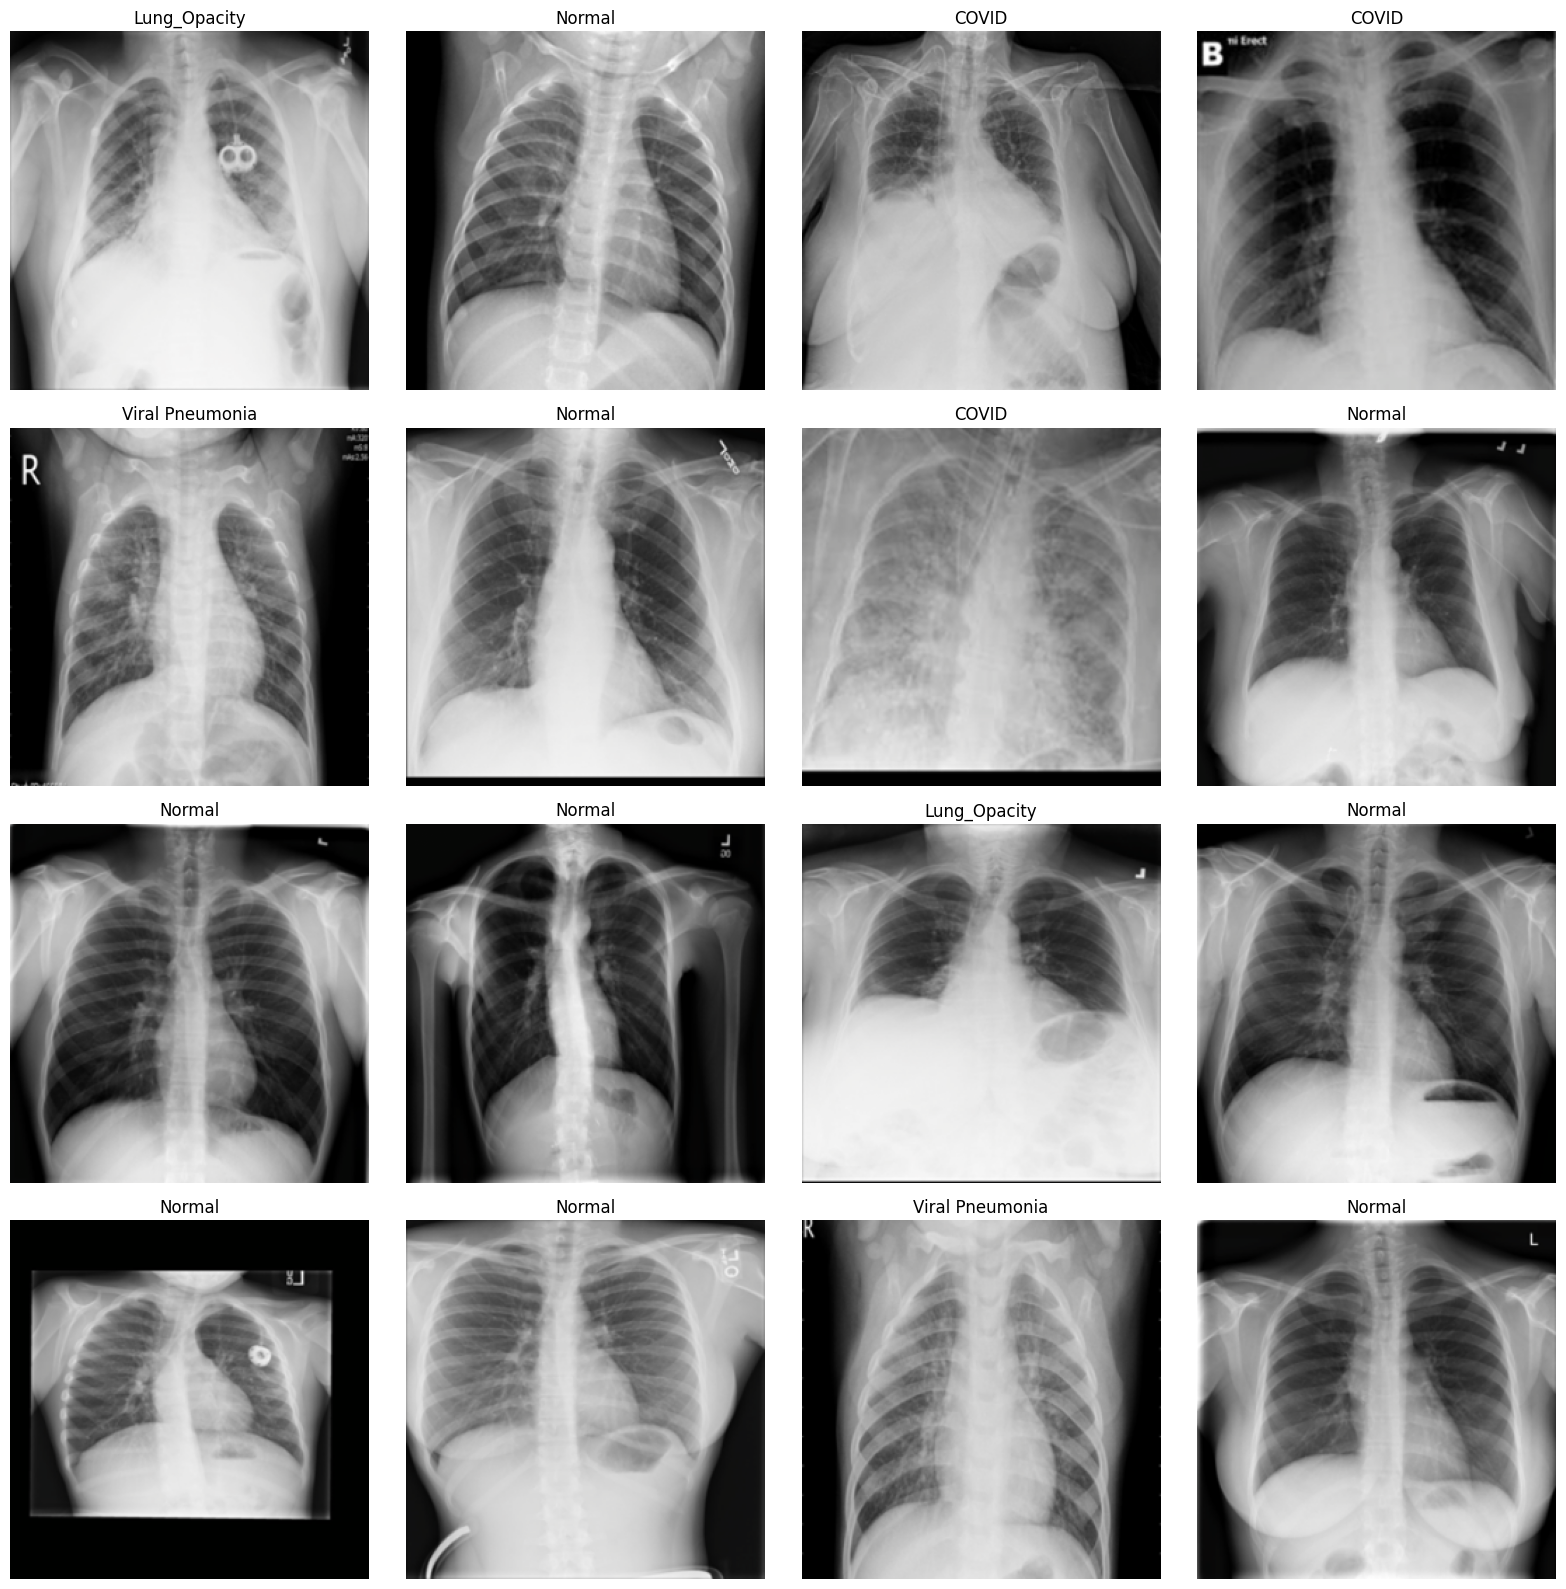

In [9]:
# usage
train_dir = "/content/data/train"
class_names = sorted(os.listdir(train_dir))
raw_dataset = ChestXRayDataset(train_dir, class_names, transform=get_val_augmentations(256))
aug_dataset = ChestXRayDataset(train_dir, class_names, transform=get_train_augmentations(256))
print("Raw images: ")
show_batch(raw_dataset, class_names)

Augmented images: 


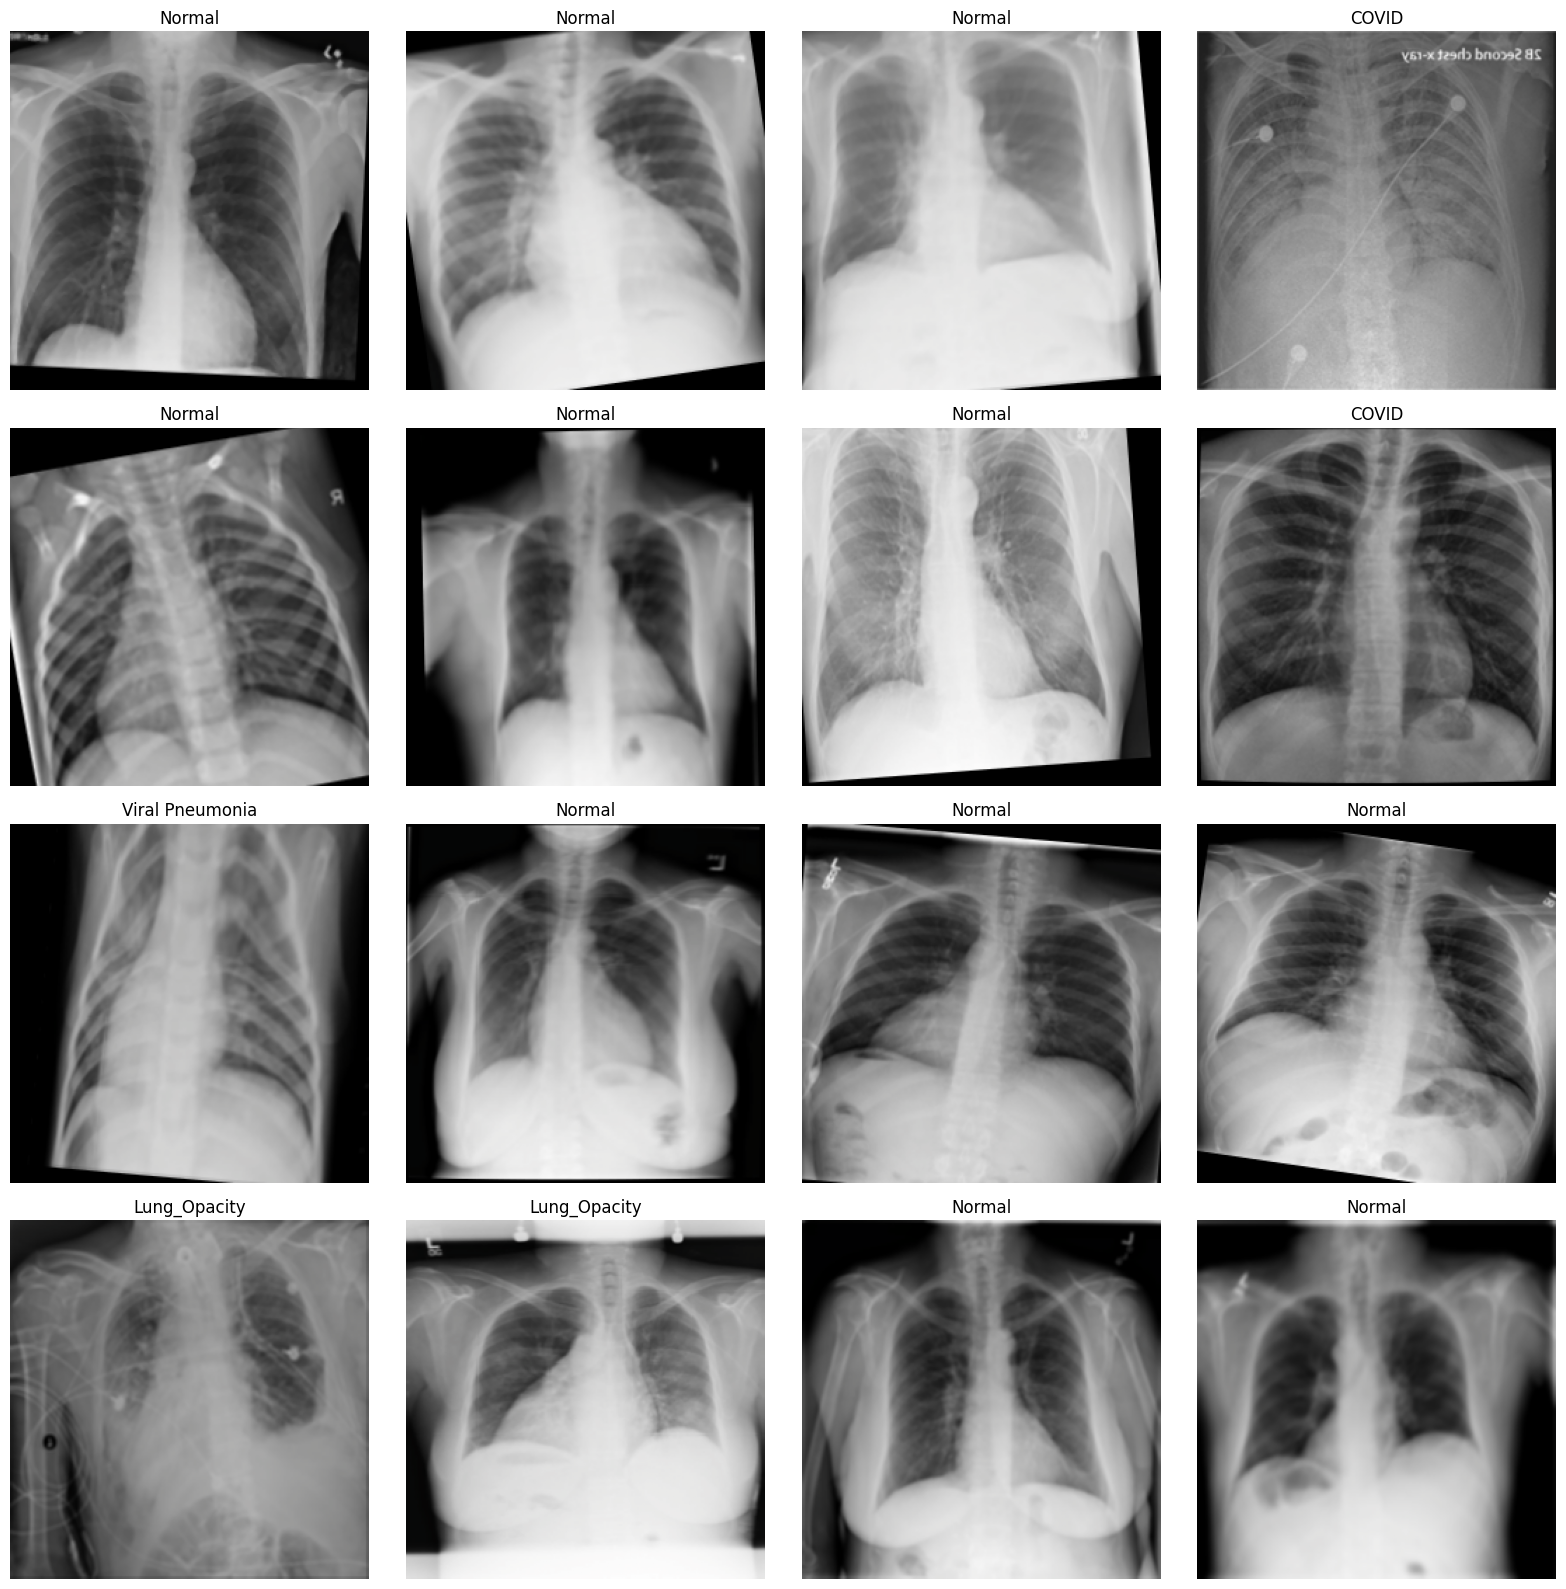

In [10]:
print("Augmented images: ")
show_batch(aug_dataset, class_names)

## 2. Model definitions

In [11]:
# class PRNetEffNetB5(nn.Module):
#   def __init__(self, num_classes: int):
#     super().__init__()
#     self.backbone = timm.create_model('efficientnet_b5', pretrained=True, features_only=True) # defining own classification head
#     num_channels = self.backbone.feature_info[-1]["num_chs"] # get the most abstract feature_map from the the backbone layer
#     self.global_pool = nn.AdapativeAvgPool2d(1)
#     self.classifier_dropout = nn.Dropout(p=0.5)
#     self.classifier = nn.Linear(num_channels, num_classes)

#   def forward(self, x):
#     features = self.backbone(x)[-1]
#     pooled = self.global_pool(features).flatten(1) # takes output of [B, C, H, W] and coverts it to [B, C, 1, 1] or [B, C]
#     dropped = self.classifier_dropout(pooled)
#     logits = self.classifier(dropped)
#     return logits

In [12]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, name, num_classes):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=True, features_only=True)
        in_ch = self.backbone.feature_info[-1]["num_chs"]
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_ch, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)[-1]  # take the deepest feature map only
        out = self.head(feats)
        return out

def create_effnet_backbone(name, num_classes):
    return EfficientNetClassifier(name, num_classes).to(device)

# def create_effnet_backbone(name, num_classes):
#     # name="efficientnet_b0" or "efficientnet_b5"
#     backbone = timm.create_model(name, pretrained=True, features_only=True)
#     in_ch = backbone.feature_info[-1]["num_chs"]  # get the most abstract feature_map from the the backbone layer
#     head = nn.Sequential(
#         nn.AdaptiveAvgPool2d(1),
#         nn.Flatten(),
#         nn.Dropout(0.5),
#         nn.Linear(in_ch, num_classes)
#     )
#     model = nn.Sequential(backbone, head)
#     return model.to(device)

In [13]:
# class VisionTransformerStub(nn.Module):
#     def __init__(self, num_classes: int):
#         super().__init__()
#         self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
#     def forward(self, x):
#         return self.vit(x)

## 3. Bias-adjustable Softmax

In [14]:
def bias_softmax(logits, exponents):
    """
    applies bias-adjustable softmax to modify class probabilities

    how it works:
    1. get normal softmax probabilities (0 to 1, sum to 1)
    2. raise each class probability to its own exponent
       - exponent > 1: makes high probs higher, low probs lower (sharpens)
       - exponent < 1: makes distribution more uniform (smooths)
       - exponent = 1: no change (normal softmax)
    3. renormalize so they still sum to 1

    example:
    - normal probs: [0.6, 0.3, 0.1]
    - exponents: [1.0, 0.5, 2.0]
    - after power: [0.6^1.0, 0.3^0.5, 0.1^2.0] = [0.6, 0.55, 0.01]
    - after normalize: [0.52, 0.47, 0.01] (approximately)

    args:
        logits: model outputs before softmax, shape (batch_size, num_classes)
        exponents: list of exponents for each class, length = num_classes

    returns:
        adjusted probabilities, same shape as input
    """
    # step 1: get normal softmax probabilities
    normal_probs = torch.softmax(logits, dim=-1)

    # step 2: raise each class to its exponent
    # convert exponents to tensor on same device as probabilities
    exp_tensor = torch.tensor(exponents, device=normal_probs.device)
    adjusted_probs = normal_probs ** exp_tensor

    # step 3: renormalize so each row sums to 1
    # sum across classes (dim=-1) and keep dimension for broadcasting
    normalized = adjusted_probs / adjusted_probs.sum(dim=-1, keepdim=True)

    return normalized


def search_best_exponents(validation_loader, trained_model, search_range=(0.1, 3.0), step_size=0.1):
    """
    finds the best exponent for each class using grid search

    the idea:
    - for each class, try different exponent values
    - pick the exponent that gives highest validation accuracy
    - do this one class at a time (greedy search)

    why this works:
    - if a class is being under-predicted, use exponent > 1 to boost it
    - if a class is being over-predicted, use exponent < 1 to dampen it
    - the paper found exponents [1.0, 0.4, 1.6] for covid/pneumonia/normal
      meaning pneumonia was over-predicted so they dampened it with 0.4

    args:
        validation_loader: dataloader for validation set
        trained_model: the model to tune (should be already trained)
        search_range: (min_exp, max_exp) to search
        step_size: how fine-grained the search is

    returns:
        list of best exponents for each class
    """
    print("collecting validation predictions for bias tuning...")

    # put model in evaluation mode
    trained_model.eval()

    # collect all validation data predictions in one go
    # this is more efficient than running inference multiple times
    all_logits = []  # model outputs (before softmax)
    all_true_labels = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            logits = trained_model(images)
            all_logits.append(logits.cpu()) # move back to CPU for storage (saves GPU memory)
            # labels might already be tensors, but ensure they're tensors
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels)
            all_true_labels.append(labels)

    # combine all batches into single tensors
    all_logits = torch.cat(all_logits, dim=0)  # shape: (total_samples, num_classes)
    all_true_labels = torch.cat(all_true_labels, dim=0)  # shape: (total_samples,)
    num_classes = all_logits.size(1)
    print(f"collected {all_logits.size(0)} samples with {num_classes} classes")

    # start with default exponents (no bias adjustment)
    best_exponents = [1.0] * num_classes

    # optimize each class exponent one by one
    for class_idx in range(num_classes):
        print(f"tuning exponent for class {class_idx}...")

        best_accuracy = 0.0
        best_exponent = 1.0

        # try different exponent values for this class
        search_values = np.arange(search_range[0], search_range[1] + step_size/2, step_size)

        for exp_value in search_values:
            # create exponent list with only this class modified
            test_exponents = best_exponents.copy()
            test_exponents[class_idx] = exp_value

            # apply bias-adjustable softmax with these exponents
            adjusted_probs = bias_softmax(all_logits, test_exponents)

            # get predictions (highest probability class)
            predictions = adjusted_probs.argmax(dim=1)

            # calculate accuracy
            correct = (predictions == all_true_labels).float()
            accuracy = correct.mean().item()

            # keep track of best exponent for this class
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_exponent = exp_value

        # update the best exponent for this class
        best_exponents[class_idx] = best_exponent
        print(f"  class {class_idx}: best_exponent={best_exponent:.2f}, accuracy={best_accuracy:.4f}")

    print(f"final best exponents: {best_exponents}")
    return best_exponents


# example usage:
"""
# after training your model, tune the bias exponents
model = your_trained_model
val_loader = your_validation_dataloader

# find best exponents
optimal_exponents = search_best_exponents(val_loader, model)

# then during inference on test set:
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(DEVICE)
        logits = model(test_images)

        # apply bias adjustment
        adjusted_probs = bias_softmax(logits, optimal_exponents)
        predictions = adjusted_probs.argmax(dim=1)

        # calculate test accuracy with bias adjustment
        ...
"""

'\n# after training your model, tune the bias exponents\nmodel = your_trained_model\nval_loader = your_validation_dataloader\n\n# find best exponents\noptimal_exponents = search_best_exponents(val_loader, model)\n\n# then during inference on test set:\nwith torch.no_grad():\n    for test_images, test_labels in test_loader:\n        test_images = test_images.to(DEVICE)\n        logits = model(test_images)\n        \n        # apply bias adjustment\n        adjusted_probs = bias_softmax(logits, optimal_exponents)\n        predictions = adjusted_probs.argmax(dim=1)\n        \n        # calculate test accuracy with bias adjustment\n        ...\n'

## 4. Training + Validation

Dropout (in your model):

Randomly sets some neurons to zero during training
Prevents neurons from becoming too dependent on each other
Applied to activations/features

Weight Decay (in optimizer):

Penalizes large weight values directly
Keeps weights small to prevent overfitting
Applied to the actual model parameters

Why Use Both?
They target different aspects of overfitting:
Dropout prevents co-adaptation - stops neurons from memorizing specific patterns together
Weight Decay prevents parameter explosion - stops individual weights from becoming too large

In [15]:
def create_warmup_cosine_scheduler(optimizer, total_epochs, warmup_epochs=3, min_lr=1e-7):
    """
    Returns a SequentialLR that:
     - linearly warms lr from 0→initial over `warmup_epochs`
     - then cosine-anneals from initial→`min_lr` over remaining epochs
     - LR = min_lr + 0.5 * (max_lr - min_lr) * (1 + cos(π * current_step / T_max))
    """
    # warmup: 0 → 1×LR
    warmup = LinearLR(
        optimizer,
        start_factor=1e-3,
        end_factor=1.0,
        total_iters=warmup_epochs
    )
    # cosine: 1×LR → min_lr
    cosine = CosineAnnealingLR(
        optimizer,
        T_max=max(total_epochs - warmup_epochs, 1), # ensures atleast T_max = 1 to avoid division by 0 in cosin formular
        eta_min=min_lr
    )
    # join them at warmup_epochs
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup, cosine],
        milestones=[warmup_epochs]
    )
    return scheduler

In [16]:
# dataset = ChestXRayDataset()
def run_configuration(
    backbone_name: str,
    image_size: int,
    use_progressive: bool,
    use_bas: bool,
    data_dir: str = "/content/data",
    total_epochs: int = 20,
    batch_size: int = 16,
    base_lr: float = 1e-4,
    weight_decay: float = 1e-4,
    early_stopping_patience: int = 5 ) -> dict:

    # basic setup stuff
    class_names = sorted(os.listdir(f"{data_dir}/train"))
    num_classes = len(class_names)
    model       = create_effnet_backbone(backbone_name, num_classes)
    criterion   = nn.CrossEntropyLoss()
    optimizer   = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler   = create_warmup_cosine_scheduler(optimizer, total_epochs)

    # figure out what image sizes we're gonna use
    # if progressive: start small and work our way up like the paper says
    # if not: just use the final size the whole time
    stages = [image_size] if not use_progressive else [256, 380, 460, 512, image_size]
    epochs_per_stage = total_epochs // len(stages)
    prev_ckpt = None
    total_train_time = total_val_time = 0.0

    # keep track of the absolute best accuracies we've seen across ALL stages
    best_overall_train_acc = 0.0
    best_overall_val_acc   = 0.0

    # go through each image size stage
    for stage_idx, sz in enumerate(stages, 1):
        print(f"starting stage {stage_idx}/{len(stages)} with image size {sz}x{sz}")

        # if we have a checkpoint from previous stage, load it up
        if prev_ckpt:
            model.load_state_dict(torch.load(prev_ckpt))
            print(f"loaded weights from {prev_ckpt}")

        # create data loaders for this specific image size
        train_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/train", class_names, transform=get_train_augmentations(sz)),
            batch_size=batch_size, shuffle=True, num_workers=4
        )
        val_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/val",   class_names, transform=get_val_augmentations(sz)),
            batch_size=batch_size, shuffle=False, num_workers=4
        )

        # early stopping stuff for this stage
        epochs_no_improve = 0
        best_stage_val_acc = 0.0

        # train for the allocated epochs at this resolution
        for epoch in range(1, epochs_per_stage+1):
            # TRAINING PHASE
            model.train()
            t0 = time.time()
            correct_tr = tot_tr = 0

            train_bar = tqdm(train_loader, desc=f"stage {stage_idx} @{sz}px - training epoch {epoch}", leave=False)
            for imgs, lbls in train_bar:
                imgs, lbls = imgs.to(device), lbls.to(device)

                # forward pass
                logits = model(imgs)
                loss   = criterion(logits, lbls)

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # track accuracy for this batch
                preds = logits.argmax(1)
                correct_tr += (preds==lbls).sum().item()
                tot_tr     += lbls.size(0)

                # update progress bar with current accuracy
                current_acc = correct_tr / tot_tr
                train_bar.set_postfix({'acc': f'{current_acc:.3f}'})

            epoch_train_time = time.time() - t0
            total_train_time += epoch_train_time

            # calculate final training accuracy for this epoch
            train_acc = correct_tr / tot_tr

            # VALIDATION PHASE
            model.eval()
            t1 = time.time()
            correct_val = tot_val = 0

            val_bar = tqdm(val_loader, desc=f"stage {stage_idx} @{sz}px - validating epoch {epoch}", leave=False)
            with torch.no_grad():
                for imgs, lbls in val_bar:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    preds = model(imgs).argmax(1)
                    correct_val += (preds==lbls).sum().item()
                    tot_val     += lbls.size(0)

                    # show current val accuracy in progress bar
                    current_val_acc = correct_val / tot_val
                    val_bar.set_postfix({'val_acc': f'{current_val_acc:.3f}'})

            epoch_val_time = time.time() - t1
            total_val_time += epoch_val_time

            val_acc = correct_val / tot_val

            print(f"epoch {epoch}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            # check if this is the best validation accuracy we've seen in this stage
            if val_acc > best_stage_val_acc:
                best_stage_val_acc = val_acc
                epochs_no_improve = 0

                # save the model - this is our best checkpoint so far
                prev_ckpt = f"{backbone_name}_stage{stage_idx}_{sz}.pth"
                torch.save(model.state_dict(), prev_ckpt)
                print(f"new best val acc: {val_acc:.4f} - saved to {prev_ckpt}")

                # update our global best accuracies if this beats them
                if train_acc > best_overall_train_acc:
                    best_overall_train_acc = train_acc
                    print(f"new overall best train acc: {train_acc:.4f}")

                if val_acc > best_overall_val_acc:
                    best_overall_val_acc = val_acc
                    print(f"new overall best val acc: {val_acc:.4f}")

            else:
                epochs_no_improve += 1
                print(f"no improvement for {epochs_no_improve} epochs")

                # early stopping check
                if epochs_no_improve >= early_stopping_patience:
                    print(f"early stopping triggered at stage {stage_idx}, epoch {epoch}")
                    break

            # update learning rate
            scheduler.step()

        # if we early stopped, don't continue to next stages
        if epochs_no_improve >= early_stopping_patience:
            print("early stopping triggered - stopping all stages")
            break

    # load up the best model we found
    if prev_ckpt:
        model.load_state_dict(torch.load(prev_ckpt))
        print(f"loaded best model from {prev_ckpt}")

    # bias-adjustable softmax tuning (only if requested)
    best_exps = [1.0] * num_classes  # default exponents
    if use_bas:
        print("tuning bias-adjustable softmax on validation set...")
        final_val_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/val", class_names, transform=get_val_augmentations(image_size)),
            batch_size=batch_size, shuffle=False, num_workers=4
        )
        best_exps = search_biased_exponents(final_val_loader, model)
        print(f"best bias exponents: {best_exps}")

    # final test evaluation
    print("running final test evaluation...")
    t2 = time.time()
    correct_test = tot_test = 0

    test_loader = DataLoader(
        ChestXRayDataset(f"{data_dir}/test", class_names, transform=get_val_augmentations(image_size)),
        batch_size=batch_size, shuffle=False, num_workers=4
    )

    model.eval()
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)

            # apply bias-adjustable softmax if we're using it
            if use_bas:
                logits = bias_softmax(logits, best_exps)

            preds = logits.argmax(1).cpu()
            correct_test += (preds==lbls).sum().item()
            tot_test += lbls.size(0)

    test_acc  = correct_test / tot_test
    test_time = time.time() - t2

    print(f"final results:")
    print(f"  best train acc (across all stages): {best_overall_train_acc:.4f}")
    print(f"  best val acc (across all stages): {best_overall_val_acc:.4f}")
    print(f"  final test acc: {test_acc:.4f}")

    # return results in the format that matches the paper's table
    return {
        "Backbone":       backbone_name.replace("efficientnet_","EffNet-").upper(),
        "Image Size":     f"{image_size}×{image_size}",
        "Progressive":    "Yes" if use_progressive else "No",
        "Bias-Softmax":   "Yes" if use_bas else "No",
        "5-Fold Accuracy": f"{best_overall_train_acc*100:.2f}%",  # best train acc seen
        "Validation Accuracy": f"{best_overall_val_acc*100:.2f}%",  # best val acc seen
        "Test Accuracy":  f"{test_acc*100:.2f}%",  # final test performance
        "Train Time (s)": f"{total_train_time:.1f}",
        "Val Time (s)":   f"{total_val_time:.1f}",
        "Test Time (s)":  f"{test_time:.1f}"
    }

In [17]:
configs = [
    ("efficientnet_b0", 512, False, False),  # EffNet-B0, 512x512, no progressive, no bias
    ("efficientnet_b0", 512, False, True),   # EffNet-B0, 512x512, no progressive, with bias
    ("efficientnet_b0", 640, True,  False),  # EffNet-B0, 640x640, with progressive, no bias
    ("efficientnet_b0", 640, True,  True),   # EffNet-B0, 640x640, with progressive, with bias
    ("efficientnet_b5", 512, False, False),  # EffNet-B5, 512x512, no progressive, no bias
    ("efficientnet_b5", 512, False, True),   # EffNet-B5, 512x512, no progressive, with bias
    ("efficientnet_b5", 640, True,  False),  # EffNet-B5, 640x640, with progressive, no bias
    ("efficientnet_b5", 640, True,  True),   # EffNet-B5, 640x640, with progressive, with bias (their best)
]

# run all experiments
results = []
for i, (backbone, size, prog, bas) in enumerate(configs, 1):
    print(f"\n🚀 experiment {i}/{len(configs)}: {backbone} | size={size} | progressive={prog} | bias_softmax={bas}")

    res = run_configuration(
        backbone_name=backbone,
        image_size=size,
        use_progressive=prog,
        use_bas=bas,
        total_epochs=20,
        batch_size=16,
        early_stopping_patience=5
    )

    results.append(res)
    print(f"✅ completed: test_acc = {res['Test Accuracy']}")

# create the results table like in the paper
print("\n" + "="*80)
print("FINAL RESULTS TABLE (reproducing paper's Table I)")
print("="*80)


🚀 experiment 1/8: efficientnet_b0 | size=512 | progressive=False | bias_softmax=False


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

starting stage 1/1 with image size 512x512


/tmp/ipython-input-7-2687364321.py:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


stage 1 @512px - training epoch 1:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 1:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 1: train_acc=0.2394, val_acc=0.2634
new best val acc: 0.2634 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.2394
new overall best val acc: 0.2634


stage 1 @512px - training epoch 2:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 2:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 2: train_acc=0.8210, val_acc=0.9239
new best val acc: 0.9239 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.8210
new overall best val acc: 0.9239


stage 1 @512px - training epoch 3:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 3:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 3: train_acc=0.9058, val_acc=0.9461
new best val acc: 0.9461 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.9058
new overall best val acc: 0.9461


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


stage 1 @512px - training epoch 4:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 4:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 4: train_acc=0.9255, val_acc=0.9485
new best val acc: 0.9485 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.9255
new overall best val acc: 0.9485


stage 1 @512px - training epoch 5:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 5:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 5: train_acc=0.9435, val_acc=0.9589
new best val acc: 0.9589 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.9435
new overall best val acc: 0.9589


stage 1 @512px - training epoch 6:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 6:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 6: train_acc=0.9508, val_acc=0.9537
no improvement for 1 epochs


stage 1 @512px - training epoch 7:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 7:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 7: train_acc=0.9581, val_acc=0.9522
no improvement for 2 epochs


stage 1 @512px - training epoch 8:   0%|          | 0/1059 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a14cbfc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a14cbfc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

stage 1 @512px - validating epoch 8:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 8: train_acc=0.9639, val_acc=0.9593
new best val acc: 0.9593 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.9639
new overall best val acc: 0.9593


stage 1 @512px - training epoch 9:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 9:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 9: train_acc=0.9700, val_acc=0.9546
no improvement for 1 epochs


stage 1 @512px - training epoch 10:   0%|          | 0/1059 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a14cbfc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a14cbfc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

stage 1 @512px - validating epoch 10:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 10: train_acc=0.9752, val_acc=0.9579
no improvement for 2 epochs


stage 1 @512px - training epoch 11:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 11:   0%|          | 0/133 [00:00<?, ?it/s]

epoch 11: train_acc=0.9804, val_acc=0.9645
new best val acc: 0.9645 - saved to efficientnet_b0_stage1_512.pth
new overall best train acc: 0.9804
new overall best val acc: 0.9645


stage 1 @512px - training epoch 12:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @512px - validating epoch 12:   0%|          | 0/133 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1251, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 113, in get
    if not self._poll(timeout):
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 440, in _poll
    r = wait([self], timeout)
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3

TypeError: object of type 'NoneType' has no len()

In [ ]:
df = pd.DataFrame(results)
print(df.to_string(index=False))

In [ ]:
# save results
df.to_csv("prnet_results.csv", index=False)
print(f"\nresults saved to prnet_results.csv")

In [ ]:
def bias_softmax(logits, exps):
    probs = torch.softmax(logits, dim=-1)
    adj   = probs ** torch.tensor(exps, device=probs.device)
    return adj / adj.sum(-1, keepdim=True)

def search_biased_exponents(val_loader, model, exp_range=(0.0,5.0), step=0.1):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs = imgs.to(device)
            all_logits.append(model(imgs).cpu())
            all_labels.append(torch.tensor(lbls))
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)
    best = [1.0]*all_logits.size(1)
    for c in range(all_logits.size(1)):
        best_acc,best_p=0,1.0
        for p in np.arange(exp_range[0], exp_range[1]+1e-9, step):
            exps = best.copy()
            exps[c] = p
            preds = bias_softmax(all_logits, exps).argmax(1)
            acc = (preds==all_labels).float().mean().item()
            if acc>best_acc: best_acc,best_p=acc,p
        best[c]=best_p
    return best
